# STA130 Course Project Tutorial Assignment 1
### Enkhzaya, Tamako, Wilson, Chenjun

In [45]:
import pandas as pd
df_indicators = pd.read_csv('country_indicators.csv')

In [46]:
df_preds = pd.read_csv('test_predictions.csv')

In [47]:
df = df_preds.merge(df_indicators, left_on='iso3', right_on='iso3', how='inner')

In [48]:
import numpy as np
from sklearn import metrics
import seaborn as sns

column_defining_groups = 'fsi_category'
# lets group countries by Human Development index category.
# could also group by continent, language, bins of under-5 mortality, etc.... any grouping you use or define
chosen_metric = 'accuracy_score'
# sklearn.metrics has many metrics appropriate for binary classification tasks.
# nice explanations here: https://neptune.ai/blog/evaluation-metrics-binary-classification
# could also chosose, e.g., 'recall_score' (which is sensitivity; but, 'recall_score' 
# will alternatively be specificity if `pos_label=False` is added as noted below), 
# 'auc' (threshold doesn't matter), 'f1_score', 'cohen_kappa_score', etc.
metric_function = getattr(metrics, chosen_metric)

chosen_metric_for_chosen_groups = list()
chosen_metric_back_into_original_data = {'ffnn': pd.Series(index=df.index, dtype=np.float64), 
                                         'xgboost': pd.Series(index=df.index, dtype=np.float64), 
                                         'transformer': pd.Series(index=df.index, dtype=np.float64)}
    
for g, rows in df.groupby(column_defining_groups):
    for model in ['ffnn', 'xgboost', 'transformer']:        
        chosen_metric_value = metric_function(rows[f"y_true_{model}"], rows[f"y_pred_{model}"])
        # Use the commented version below when using 'recall_score' to make it "specificity" 
        # rather than sensitivity which is what 'recall_score' gives if `pos_label=False` isn't used
        #chosen_metric_value = metric_function(rows[f"y_true_{model}"], 
        #                                      rows[f"y_pred_{model}"], pos_label=False) # specificity 
        
        chosen_metric_back_into_original_data[model][rows.index] = chosen_metric_value
        chosen_metric_for_chosen_groups.append((model, g, chosen_metric_value))

cm_bigger_better = sns.light_palette("green", as_cmap=True)
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html#Styler-Object-and-Customising-the-Display
styler = ( pd.DataFrame(chosen_metric_for_chosen_groups, 
                        columns=('model', column_defining_groups, chosen_metric))
            .sort_values(column_defining_groups).style
            .background_gradient(cmap=cm_bigger_better)
            .format(precision=3).hide(axis="index"))
styler

model,fsi_category,accuracy_score
ffnn,Alert,0.386
xgboost,Alert,0.300
transformer,Alert,0.471
ffnn,Stable,0.898
xgboost,Stable,0.750
transformer,Stable,0.716
ffnn,Sustainable,0.943
xgboost,Sustainable,0.829
transformer,Sustainable,0.943
ffnn,Warning,0.737


In [49]:
ffnn = chosen_metric_back_into_original_data['ffnn']
xgboost = chosen_metric_back_into_original_data['xgboost']
transformer = chosen_metric_back_into_original_data['transformer']

# plot the distribution of the metric for each model
import plotly.express as px
fig = px.histogram(df, x=ffnn, title='FFNN')
fig.show()

In [50]:
fig2 = px.histogram(df, x=xgboost, title='XGBoost')
fig2.show()

In [51]:
fig3 = px.histogram(df, x=transformer, title='Transformer')
fig3.show()

In [52]:
# plot all 3 models on the same plot
import plotly.graph_objects as go
fig4 = go.Figure()
fig4.add_trace(go.Histogram(x=ffnn, name='FFNN'))
fig4.add_trace(go.Histogram(x=xgboost, name='XGBoost'))
fig4.add_trace(go.Histogram(x=transformer, name='Transformer'))
fig4.update_layout(barmode='overlay')
fig4.update_traces(opacity=0.75)
fig4.update_layout(title_text='Comparison of models')
fig4.update_layout(xaxis_title_text='Metric value')
fig4.update_layout(yaxis_title_text='Count')
fig4.show()

In [53]:
fig = []
for model,colors in zip(['ffnn', 'xgboost', 'transformer'],['Reds', 'Blues', 'Greens']):
    fig += [go.Figure(data = go.Choropleth(locations=df_preds['iso3'], text=df_preds['iso3'], 
                                           z=chosen_metric_back_into_original_data[model], 
               colorscale = colors, autocolorscale=False, reversescale=False, marker_line_color='darkgray',
               marker_line_width=0.5, colorbar_tickprefix='', colorbar_title=model+" "+chosen_metric))]
fig[0].show()
fig[1].show()
fig[2].show()

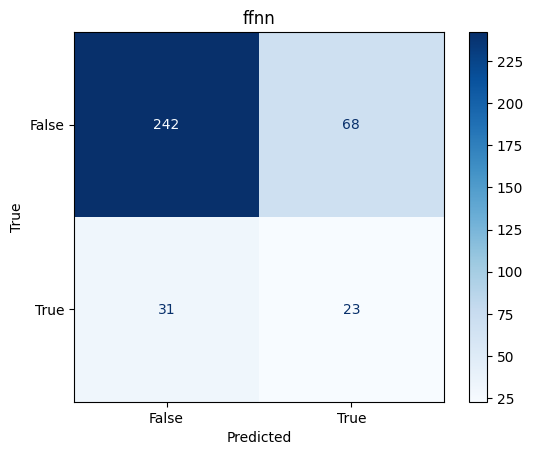

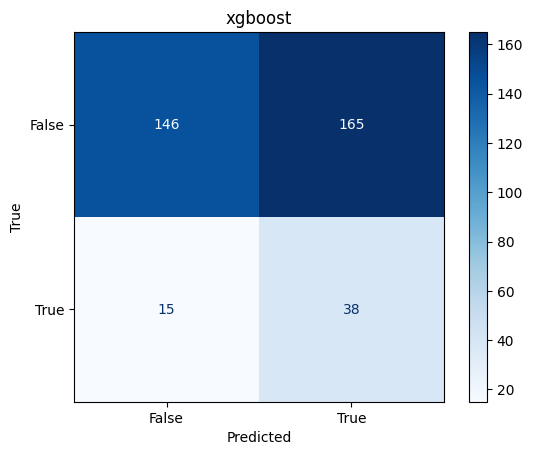

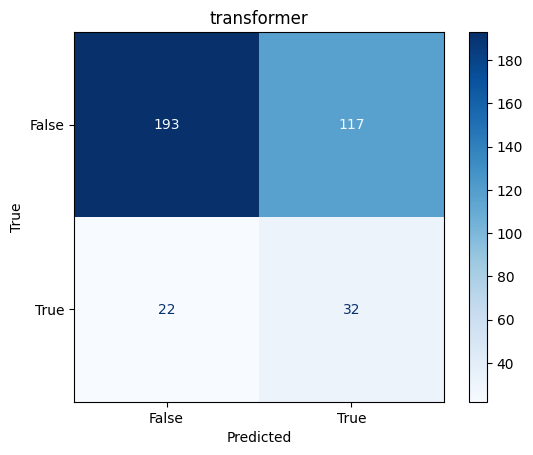

In [54]:
# create confusion matrices
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for model in ['ffnn', 'xgboost', 'transformer']:
    cm = confusion_matrix(df[f"y_true_{model}"], df[f"y_pred_{model}"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
    disp.plot(cmap='Blues')
    disp.ax_.set_title(model)
    disp.ax_.set_xlabel('Predicted')
    disp.ax_.set_ylabel('True')
    disp.ax_.set_xticklabels(['False', 'True'])
    disp.ax_.set_yticklabels(['False', 'True'])
    disp.ax_.grid(False)
    disp.ax_.set_ylim([1.5, -0.5]) # to fix bug in matplotlib
    disp.ax_.set_xlim([-0.5, 1.5]) # to fix bug in matplotlib
    disp.ax_.set_aspect('equal') # to fix bug in matplotlib
    disp.ax_.set_aspect('equal') # to fix bug in matplotlib